### Open Source Summarize Conversation Transcript

- Open-Source Summarizer only able to return answer in paragraphs.

- After testing result generated was not ideal for multi-speaker summary. 

- Instead use close-source chat model with prompt engineering E.g. **"closed_source_PROMPT_ENGINERERING.ipynb"**

### Install & Import Necessary Libraries

In [21]:
import time
import sys
sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from  langchain import LLMChain, HuggingFacePipeline, PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from sentence_transformers import SentenceTransformer, util
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans


import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def summ_pipeline(model, tokenizer, chain_type, max_length, prompt=False):
  pipeline = transformers.pipeline(
      "summarization",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.bfloat16,
      trust_remote_code=True,
      device_map="auto",
      max_length=max_length,
      do_sample=True,
      top_k=10,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
  )
  llm = HuggingFacePipeline(pipeline = pipeline)

  if chain_type == "map_reduce":
    if prompt:
      prompt_template = """Summarize this: ```{text}```"""
      prompt_message = PromptTemplate(template=prompt_template, input_variables=["text"])
      
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length, prompt=prompt_message)
    else:
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length)
  else:
    # can't get it to work with refine and stuff, think they updated the library but no documentation
    # on how to set token_max
    summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type)
  return summary_chain

In [2]:
models = ["Salesforce/dialogstudio-t5-base-v1.0"]


df_models= pd.DataFrame(models, columns=["Models"])
df_models

,Models
0,Salesforce/dialogstudio-t5-base-v1.0


In [4]:
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens' ,'transcript','original summary', 'summary', 'rouge','bert_score', 'bleu', 'time_taken', 'grammar', 'readability'])
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability


#### Loading Data

In [5]:
df = pd.read_excel("../data/qmsum_test.xlsx")

df_test = df.head(5)

df_test

,transcript,summary
0,Grad C : Nice . Grad D : OK . Grad A : to {dis...,The group discussed the first version of the B...
1,"Grad A : Alright , so I 'm - I should read all...",The group members mainly talked about the deta...
2,"Grad A : Ah , so comfortable . Grad F : Smooth...",The meeting was taken up by discussion about a...
3,"Grad B : OK , PhD F : That 's looks strange . ...","In this meeting, the speakers addressed issues..."
4,Professor E : Alright . Grad C : So are you {d...,The group discussed recording equipment issues...


#### MapReduce Method

In [7]:
for model_name in df_models['Models']:
    print(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    for index, row in df_test.iterrows():
        method = "MapReduce"
        
        # get the summary
        start_time = time.time()


        max_tokens = tokenizer.model_max_length
        summary_chain = summ_pipeline(model, tokenizer, "map_reduce", max_tokens)

        # Used for efficient tokenization and processing of long texts when working with language models
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row["transcript"]])
        summary = summary_chain.run(docs)


        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index()
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


Salesforce/dialogstudio-t5-base-v1.0


tokenizer_config.json: 100%|██████████| 2.35k/2.35k [00:00<00:00, 2.34MB/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Zhang Xiang\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 70.71it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\tr

done in 0.84 seconds, 1.18 sentences/sec


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16968\1625815826.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)
Your max_length is set to 512, but your input_length is only 371. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=185)
Your max_length is set to 512, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 512, but your input_length is only 238. S

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.23it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 0.76 seconds, 1.32 sentences/sec


Your max_length is set to 512, but your input_length is only 409. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=204)
Your max_length is set to 512, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 512, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.01it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 0.70 seconds, 1.43 sentences/sec


Your max_length is set to 512, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)
Your max_length is set to 512, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 512, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able 

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 397.56it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 0.64 seconds, 1.56 sentences/sec


Your max_length is set to 512, but your input_length is only 297. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=148)
Your max_length is set to 512, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 493.80it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 0.62 seconds, 1.61 sentences/sec


In [9]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,Salesforce/dialogstudio-t5-base-v1.0,MapReduce,512,Grad C : Nice . Grad D : OK . Grad A : to {dis...,The group discussed the first version of the B...,Grad Bhaskara talks about the admission fee an...,"[{'rouge-1': {'r': 0.031578947368421054, 'p': ...","([tensor(0.8197)], [tensor(0.8037)], [tensor(0...",2.846070e-233,111.841398,"[Offset 5, length 8, Rule ID: MORFOLOGIK_RULE_...",100 words required.
1,Salesforce/dialogstudio-t5-base-v1.0,MapReduce,512,"Grad A : Alright , so I 'm - I should read all...",The group members mainly talked about the deta...,"""""Grad A, Grad B, Nancy, Nancy and Ami are goi...","[{'rouge-1': {'r': 0.08333333333333333, 'p': 0...","([tensor(0.8195)], [tensor(0.8246)], [tensor(0...",2.296016e-155,137.580119,"[Offset 35, length 3, Rule ID: MORFOLOGIK_RULE...",100 words required.
2,Salesforce/dialogstudio-t5-base-v1.0,MapReduce,512,"Grad A : Ah , so comfortable . Grad F : Smooth...",The meeting was taken up by discussion about a...,""" Running out of film is different from being ...","[{'rouge-1': {'r': 0.06172839506172839, 'p': 0...","([tensor(0.8196)], [tensor(0.8011)], [tensor(0...",7.719183e-80,119.740855,"[Offset 89, length 3, Rule ID: COMMA_PARENTHES...",100 words required.
3,Salesforce/dialogstudio-t5-base-v1.0,MapReduce,512,"Grad B : OK , PhD F : That 's looks strange . ...","In this meeting, the speakers addressed issues...",Professors discuss the 'disfmarker ' glitch at...,"[{'rouge-1': {'r': 0.09090909090909091, 'p': 0...","([tensor(0.8413)], [tensor(0.8542)], [tensor(0...",2.986240e-156,132.872282,"[Offset 24, length 10, Rule ID: MORFOLOGIK_RUL...",100 words required.
4,Salesforce/dialogstudio-t5-base-v1.0,MapReduce,512,Professor E : Alright . Grad C : So are you {d...,The group discussed recording equipment issues...,"Professor E, Postdoc F and Grad C are going to...","[{'rouge-1': {'r': 0.06172839506172839, 'p': 0...","([tensor(0.8342)], [tensor(0.8198)], [tensor(0...",1.394024e-232,124.668619,[],100 words required.


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16968\4287741633.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16968\4287741633.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16968\4287741633.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


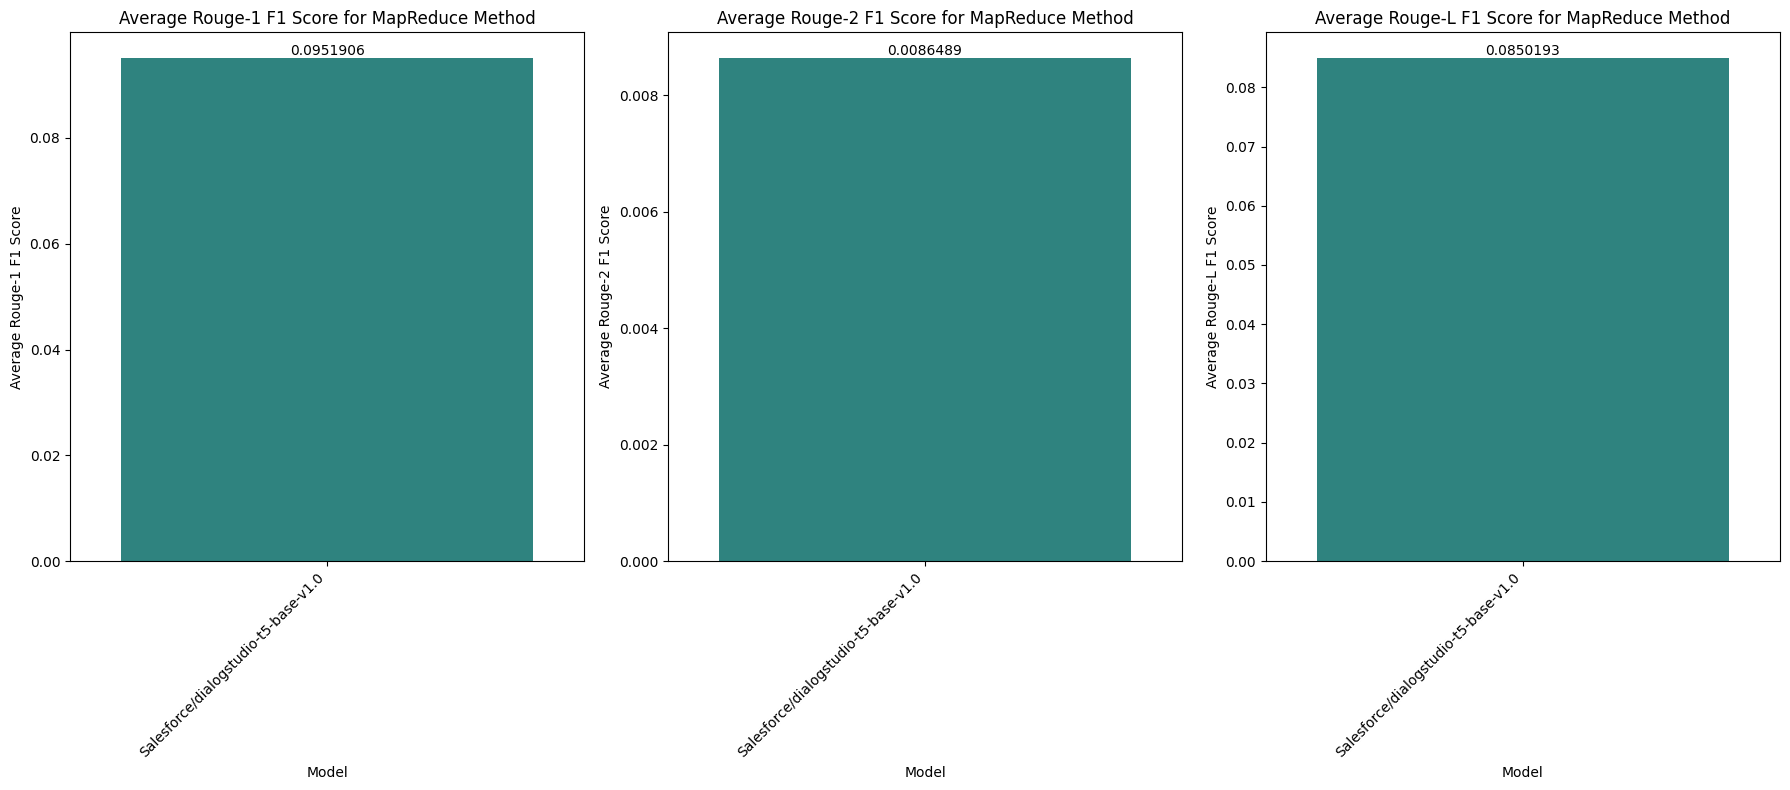

In [24]:
# Filter removed models
# df_scores = df_scores[df_scores['model'].isin(df_avg_last_f1['model'])]

from ast import literal_eval

# Convert string representation of dict to a dictionary
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: eval(str(x))[0])

# Extract Rouge-1, Rouge-2, and Rouge-L F1 scores from the dictionary
df_scores['rouge-1_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-1']['f'])
df_scores['rouge-2_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-2']['f'])
df_scores['rouge-l_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-l']['f'])

# Filter data for MapReduce method
df_scores_mapreduce = df_scores[df_scores['method'] == 'MapReduce']

# Calculate the average of Rouge-1, Rouge-2, and Rouge-L F1 scores for each model
avg_rouge1 = df_scores_mapreduce.groupby('model')['rouge-1_f'].mean().reset_index()
avg_rouge2 = df_scores_mapreduce.groupby('model')['rouge-2_f'].mean().reset_index()
avg_rouge_l = df_scores_mapreduce.groupby('model')['rouge-l_f'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot Charts
sns.barplot(x='model', y='rouge-1_f', data=avg_rouge1, palette='viridis', ax=axes[0], hue='model')
axes[0].set_title('Average Rouge-1 F1 Score for MapReduce Method')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Average Rouge-1 F1 Score')
# axes[0].tick_params(axis='x', labelrotation = 45)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

for container in axes[0].containers:
    axes[0].bar_label(container)

sns.barplot(x='model', y='rouge-2_f', data=avg_rouge2, palette='viridis', ax=axes[1], hue='model')
axes[1].set_title('Average Rouge-2 F1 Score for MapReduce Method')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Average Rouge-2 F1 Score')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
for container in axes[1].containers:
    axes[1].bar_label(container)

sns.barplot(x='model', y='rouge-l_f', data=avg_rouge_l, palette='viridis', ax=axes[2], hue='model')
axes[2].set_title('Average Rouge-L F1 Score for MapReduce Method')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Average Rouge-L F1 Score')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
for container in axes[2].containers:
    axes[2].bar_label(container)




plt.tight_layout()

plt.show()